In [5]:
import os
import cv2 as cv
import numpy as np
import pandas as pd
from tqdm import tqdm
import shutil
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


1. os untuk akses direktori lokal/navigasi direktori
2. cv pemrosesan gambar
3. numpy komputasi numerik
4. matplotlib untuk visualisasi data
5. tqdm (taqaddum) untuk estimasi waktu saat pemrosesan
6. Pandas untuk manipulasi dan analisis data.
7. shutil untuk operasi file dan direktori
8. sklearn untuk 
    - mengimport Support Vector Classifier, 
    - K-Neighbors Classifier, 
    - Random Forest Classifier, 
    - SimpleImputer untuk imputasi nilai yang hilang, 
    - impor StandardScaler untuk standardisasi fitur, 
    - train_test_split untuk membagi dataset menjadi data latih dan uji (val)
    - menampilkan akurasi, presisi, recall, dan f1 score


Load image dengan format rgb terhadap direktori Dataset_F dengan label/sub folder 'fresh_peaches', 'fresh_pomegranates', 'fresh_strawberries', 'rotten_peaches', 'rotten_pomegranates', 'rotten_strawberries'

In [11]:
def load_images_with_labels(base_folder, subfolders, target_size=(100, 100), sample_count=5):
    data = []
    labels = []
    count = {}
    sample = {folder: [] for folder in subfolders}
    
    for folder_name in subfolders:
        folder_path = os.path.join(base_folder, folder_name)
        count[folder_name] = 0
        
        for filename in os.listdir(folder_path):
            img_path = os.path.join(folder_path, filename)
            img = cv.imread(img_path, cv.IMREAD_COLOR)  
            if img is not None:
                img = cv.cvtColor(img, cv.COLOR_BGR2RGB)  
                img = cv.resize(img, target_size)
                data.append(img)
                labels.append(folder_name)
                
                count[folder_name] += 1
                
                if len(sample[folder_name]) < sample_count:
                    sample[folder_name].append(img)
    
    return np.array(data), np.array(labels), count, sample

# Define base folder and subfolders
base_folder = 'Dataset_F'
subfolders = ['fresh_peaches', 'fresh_pomegranates', 'fresh_strawberries', 'rotten_peaches', 'rotten_pomegranates', 'rotten_strawberries']

data, labels, count, sample = load_images_with_labels(base_folder, subfolders)
print(f"Loaded {len(data)} images")

Loaded 600 images


In [12]:
def data_distribution(labels):
    distribution = pd.Series(labels).value_counts()
    return distribution

distribution = data_distribution(labels)
print('Jumlah data:', len(labels))
print('\nDistribusi data per kategori:')
print(distribution.to_string())


Jumlah data: 600

Distribusi data per kategori:
fresh_peaches          100
fresh_pomegranates     100
fresh_strawberries     100
rotten_peaches         100
rotten_pomegranates    100
rotten_strawberries    100


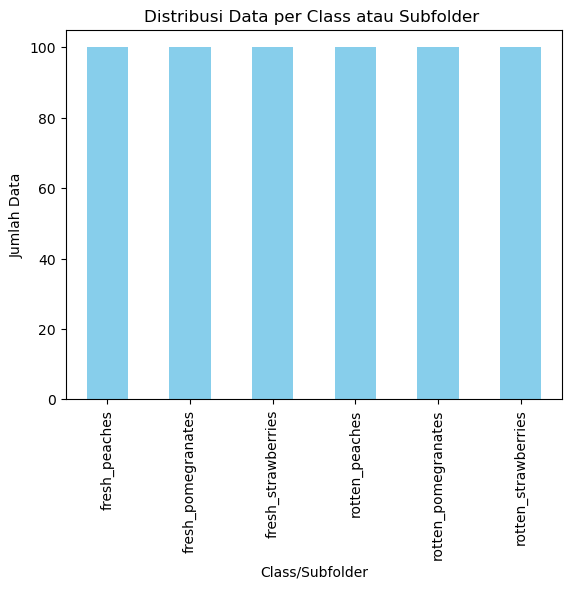

In [13]:
def plot_data_distribution(distribution):
    distribution.plot(kind='bar', color='skyblue')
    plt.title('Distribusi Data per Class atau Subfolder ')
    plt.xlabel('Class/Subfolder')
    plt.ylabel('Jumlah Data')
    plt.show()

plot_data_distribution(distribution)

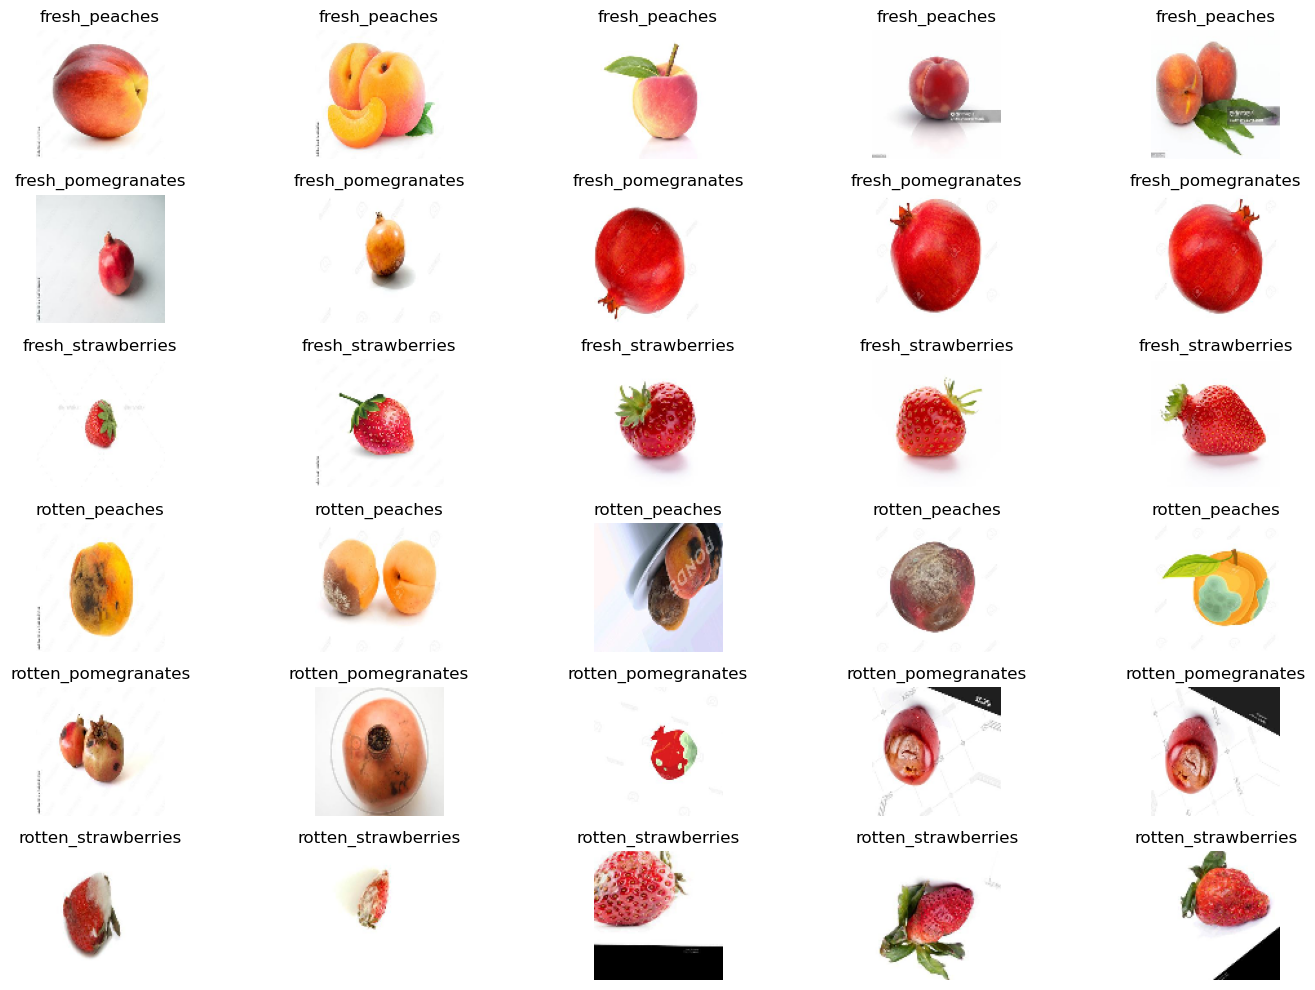

In [15]:
# Sample
fig, axs = plt.subplots(len(subfolders), 5, figsize=(15, 10))
for i, folder in enumerate(subfolders):
    for j in range(5):
        if j < len(sample[folder]):
            axs[i, j].imshow(sample[folder][j])
            axs[i, j].set_title(f"{folder}")
        axs[i, j].axis('off')

plt.tight_layout()
plt.show()

## Augmentasi


In [16]:
def horizontal_flip(image):
    return cv.flip(image, 1)

def vertical_flip(image):
    return cv.flip(image, 0)

def rotate_image(image, angle):
    (height, width) = image.sheightape[:2]
    center = (width // 2, height // 2)
    M = cv.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv.warpAffine(image, M, (width, height))
    return rotated

In [17]:
data = []
labels = []

base_dir = 'Dataset_F'
label_dirs = os.listdir(base_dir)

for label in label_dirs:
    label_dir = os.path.join(base_dir, label)
    if os.path.isdir(label_dir):
        for img_name in os.listdir(label_dir):
            img_path = os.path.join(label_dir, img_name)
            img = cv.imread(img_path)
            if img is not None:
                data.append(img)
                labels.append(label)

Membuat direktori baru bernama 'Dataset_F_Augmen' untuk menyimpan gambar hasil augmentasi terhadap direktori Dataset_F

In [19]:
augmented_data = []
augmented_labels = []
img_paths = []

output_base_dir = 'Dataset_F_Augmen'
if not os.path.exists(output_base_dir):
    os.makedirs(output_base_dir)

for label in set(labels):
    label_dir = os.path.join(output_base_dir, label)
    if not os.path.exists(label_dir):
        os.makedirs(label_dir)

for i, (img, label) in enumerate(zip(data, labels)):
    label_dir = os.path.join(output_base_dir, label)
    
    img_path = os.path.join(label_dir, f"{label}_{i}_original.jpg")
    cv.imwrite(img_path, img)
    augmented_data.append(cv.cvtColor(img, cv.COLOR_BGR2RGB))  
    augmented_labels.append(label)
    img_paths.append(img_path)

    # Horizontal flip
    au1 = horizontal_flip(img)
    img_path = os.path.join(label_dir, f"{label}_{i}_horizontal_flip.jpg")
    cv.imwrite(img_path, au1)
    augmented_data.append(cv.cvtColor(au1, cv.COLOR_BGR2RGB))  
    augmented_labels.append(label)
    img_paths.append(img_path)

    # Vertical flip
    au2 = vertical_flip(img)
    img_path = os.path.join(label_dir, f"{label}_{i}_vertical_flip.jpg")
    cv.imwrite(img_path, au2)
    augmented_data.append(cv.cvtColor(au2, cv.COLOR_BGR2RGB))  
    augmented_labels.append(label)
    img_paths.append(img_path)

    # Rotate 90 
    au3 = rotate_image(img, 90)
    img_path = os.path.join(label_dir, f"{label}_{i}_rotate_90.jpg")
    cv.imwrite(img_path, au3)
    augmented_data.append(cv.cvtColor(au3, cv.COLOR_BGR2RGB))  
    augmented_labels.append(label)
    img_paths.append(img_path)

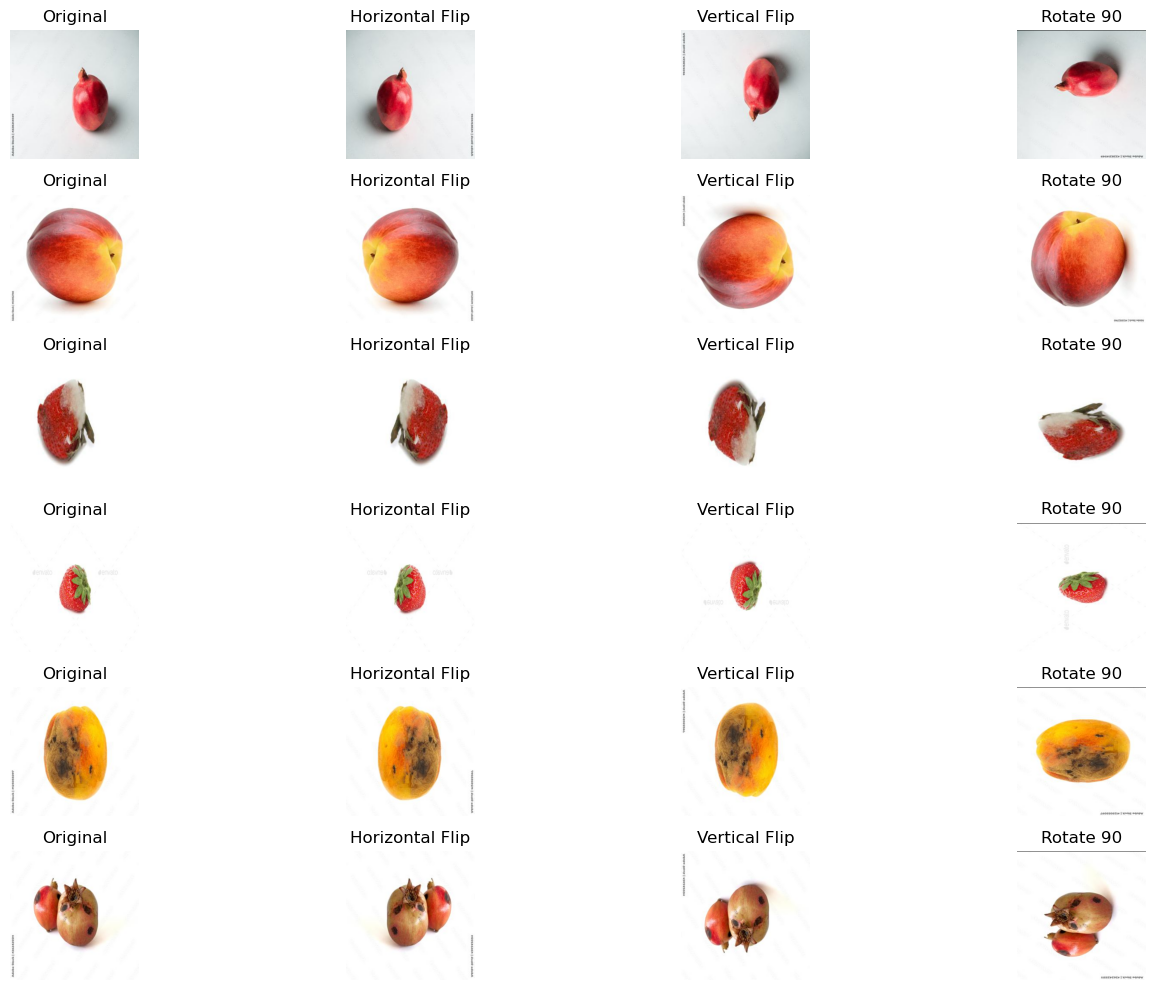

Jumlah Data Sebelum Augmentasi: 600
Jumlah Data Setelah Augmentasi: 2400


In [20]:
# Samples
def plot_augmented_samples(data, labels, num_samples=1):
    sample_indices = {label: [] for label in set(labels)}
    
    for idx, label in enumerate(labels):
        if len(sample_indices[label]) < num_samples * 4:  
            sample_indices[label].append(idx)
    
    fig, axes = plt.subplots(len(sample_indices), num_samples * 4, figsize=(15, 10))
    
    if len(sample_indices) == 1:
        axes = [axes]
    
    titles = ['Original', 'Horizontal Flip', 'Vertical Flip', 'Rotate 90']
    for i, (label, indices) in enumerate(sample_indices.items()):
        for j in range(num_samples * 4):
            axes[i][j].imshow(data[indices[j]])
            axes[i][j].set_title(f"{titles[j % 4]}")
            axes[i][j].axis('off')
        
        axes[i][0].set_ylabel(label, rotation=90, size='large')
    
    plt.tight_layout()
    plt.show()

plot_augmented_samples(augmented_data, augmented_labels, num_samples=1)

print('Jumlah Data Sebelum Augmentasi:', len(data))
print('Jumlah Data Setelah Augmentasi:', len(augmented_data))

Splitting data dengan rasio 7:3 dengan rasio 7 untuk data training dan 3 untuk data validasi, dataframe digunakan untuk organisis dan pengelolaan direktori agar sesuai dengan format Dataset awal

In [21]:
def split_data(X, y, test_size=0.3, random_state=None):
    return train_test_split(X, y, test_size=test_size, random_state=random_state)

all_data = pd.DataFrame({'image_path': img_paths, 'label': augmented_labels})

X = all_data['image_path'].values
y = all_data['label'].values

train_test_ratio = 0.7
test_size = 1 - train_test_ratio

X_train, X_test, y_train, y_test = split_data(X, y, test_size=test_size)

print("Jumlah data training:", len(X_train))
print("Jumlah data validasi:", len(X_test))

Jumlah data training: 1920
Jumlah data validasi: 480


Menyimpan gambar hasil splitting kedalam direktori data_train untuk data training dan data_val untuk data validasi, shutil digunakan untuk mengcopy atau imwrite gambar agar tersimpan pada direktori yang dituju

In [22]:
def save_images_to_folder(image_paths, labels, folder_name):
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)
    
    unique_labels = np.unique(labels)
    for label in unique_labels:
        label_folder = os.path.join(folder_name, label)
        if not os.path.exists(label_folder):
            os.makedirs(label_folder)

    for img_path, label in zip(image_paths, labels):
        label_folder = os.path.join(folder_name, label)
        shutil.copy(img_path, label_folder)

# Simpan data training dan testing ke folder
save_images_to_folder(X_train, y_train, 'data_train')
save_images_to_folder(X_test, y_test, 'data_val')

print("Data berhasil disimpan ke folder 'data_train' dan 'data_val'")

Data berhasil disimpan ke folder 'data_train' dan 'data_val'


Terdapat preprocessing normalisasi standarisasi (scaler) untuk melakukan distribusi nilai mean, bersamaan dengan SimpleImputer untuk mengisi nilai input yang kosong.

Ada juga flatten untuk mengubah dimensi gambar training dan validasi dari 2D menjadi 1D. Kemudian imputer untuk mengisi nilai yang kosong setelah di flatten kemudian dilakukan normalisasi dengan scaler untuk menstandarisasi fitur pada data pelatihan maupun data validasi

In [23]:
scaler = StandardScaler()
imputer = SimpleImputer(strategy='mean')

X_train_images = np.array([cv.imread(path) for path in X_train])
X_test_images = np.array([cv.imread(path) for path in X_test])

# Flatten the images
X_train_flatten = X_train_images.reshape(X_train_images.shape[0], -1)
X_test_flatten = X_test_images.reshape(X_test_images.shape[0], -1)

# Impute and scale
XTrainImputed = imputer.fit_transform(X_train_flatten)
XTestImputed = imputer.transform(X_test_flatten)
XTrainNorm = scaler.fit_transform(XTrainImputed)
XTestNorm = scaler.transform(XTestImputed)

Uji coba model KNN, SVC, dan RF sebelum dilakukan preprocessing lanjutan

In [24]:
models = [
    ('KNN', KNeighborsClassifier(n_neighbors=5)),
    ('SVC', SVC()),
    ('Random Forest', RandomForestClassifier(n_estimators=100))
]

predictions = {}
for name, model in tqdm(models, desc="Training and Predicting"):
    print(f"Training {name}...")
    model.fit(XTrainNorm, y_train)
    
    print(f"Predicting with {name}...")
    predictions[name] = model.predict(XTestNorm)

y_pred_knn = predictions['KNN']
y_pred_svc = predictions['SVC']
y_pred_rf = predictions['Random Forest']
# Time 12min

Training and Predicting:   0%|          | 0/3 [00:00<?, ?it/s]

Training KNN...
Predicting with KNN...


Training and Predicting:  33%|███▎      | 1/3 [00:05<00:11,  5.73s/it]

Training SVC...
Predicting with SVC...


Training and Predicting:  67%|██████▋   | 2/3 [12:14<07:11, 431.33s/it]

Training Random Forest...
Predicting with Random Forest...


Training and Predicting: 100%|██████████| 3/3 [12:58<00:00, 259.62s/it]


Menampilkan akurasi KNN, SVC, dan RF

In [25]:
all_labels = np.unique(np.concatenate((y_train, y_test)))

def evaluasi(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    return accuracy, precision, recall, f1

# Evaluasi model
akurasiknn, presisiknn, recalknn, f1knn = evaluasi(y_test, y_pred_knn)
akurasisvc, presisisvc, recalsvc, f1svc = evaluasi(y_test, y_pred_svc)
akurasirf, presisirf, recalrf, f1rf = evaluasi(y_test, y_pred_rf)

print(f"Akurasi KNN : {akurasiknn * 100:.2f}%")
print(f"Akurasi SVC  : {akurasisvc * 100:.2f}%")
print(f"Akurasi RF  : {akurasirf * 100:.2f}%")

header = f"{' |':<10}  │ {'Accuracy':<10} │ {'Precision':<10} │ {'Recall':<10} │ {'F1 Score':<10} |"
separator = "─" * 62

top_border = f" ┌{'─' * 10}┬{'─' * 12}┬{'─' * 12}┬{'─' * 12}┬{'─' * 12}┐"
mid_border = f" ├{'─' * 10}┼{'─' * 12}┼{'─' * 12}┼{'─' * 12}┼{'─' * 12}┤"
bottom_border = f" └{'─' * 10}┴{'─' * 12}┴{'─' * 12}┴{'─' * 12}┴{'─' * 12}┘"

row_knn = f"{' |KNN':<10}  │ {akurasiknn:<10.8f} │ {presisiknn:<10.8f} │ {recalknn:<10.8f} │ {f1knn:<10.8f} |"
row_svc = f"{' |SVC':<10}  │ {akurasisvc:<10.8f} │ {presisisvc:<10.8f} │ {recalsvc:<10.8f} │ {f1svc:<10.8f} |"
row_rf = f"{' |RF':<10}  │ {akurasirf:<10.8f} │ {presisirf:<10.8f} │ {recalrf:<10.8f} │ {f1rf:<10.8f} |"

print(top_border)
print(header)
print(mid_border)
print(row_knn)
print(mid_border)
print(row_svc)
print(mid_border)
print(row_rf)
print(bottom_border)

Akurasi KNN : 50.83%
Akurasi SVC  : 58.33%
Akurasi RF  : 62.50%
 ┌──────────┬────────────┬────────────┬────────────┬────────────┐
 |          │ Accuracy   │ Precision  │ Recall     │ F1 Score   |
 ├──────────┼────────────┼────────────┼────────────┼────────────┤
 |KNN       │ 0.50833333 │ 0.50527081 │ 0.50833333 │ 0.48172084 |
 ├──────────┼────────────┼────────────┼────────────┼────────────┤
 |SVC       │ 0.58333333 │ 0.60083655 │ 0.58333333 │ 0.58086815 |
 ├──────────┼────────────┼────────────┼────────────┼────────────┤
 |RF        │ 0.62500000 │ 0.62674622 │ 0.62500000 │ 0.62305545 |
 └──────────┴────────────┴────────────┴────────────┴────────────┘


## Proses Klasifikasi Buah Segar dan Busuk

#### Tensorflow
1. Tenforflow digunakan untuk pemrosesan machine learning dan deep learning. 
2. Ada pula keras yang digunakan untuk pelatihan model machine learning.
    - Layer digunakan untuk menyediakan layer neural network yang dalam kasus ini digunakan terhadap model sekuensial dengan optimizer adam.
    - sekuensial untuk menampilkan model machine learning dengan optimizer adam yang memuat layer-layer 

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

Splitting data training dan validasi dengan library tensorflow

In [3]:
## Training
dataset_url = "Dataset_F_Augmen"
img_height = 100
img_width = 100
batch_size = 32

# Train split
train_ds = tf.keras.utils.image_dataset_from_directory( 
    dataset_url, 
    validation_split=0.2, 
    subset='training', 
    seed=256, 
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Validation split
val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_url,
    validation_split=0.2,
    subset='validation',
    seed=256,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 3424 files belonging to 6 classes.
Using 2740 files for training.
Found 3424 files belonging to 6 classes.
Using 684 files for validation.


['fresh_peaches', 'fresh_pomegranates', 'fresh_strawberries', 'rotten_peaches', 'rotten_pomegranates', 'rotten_strawberries']


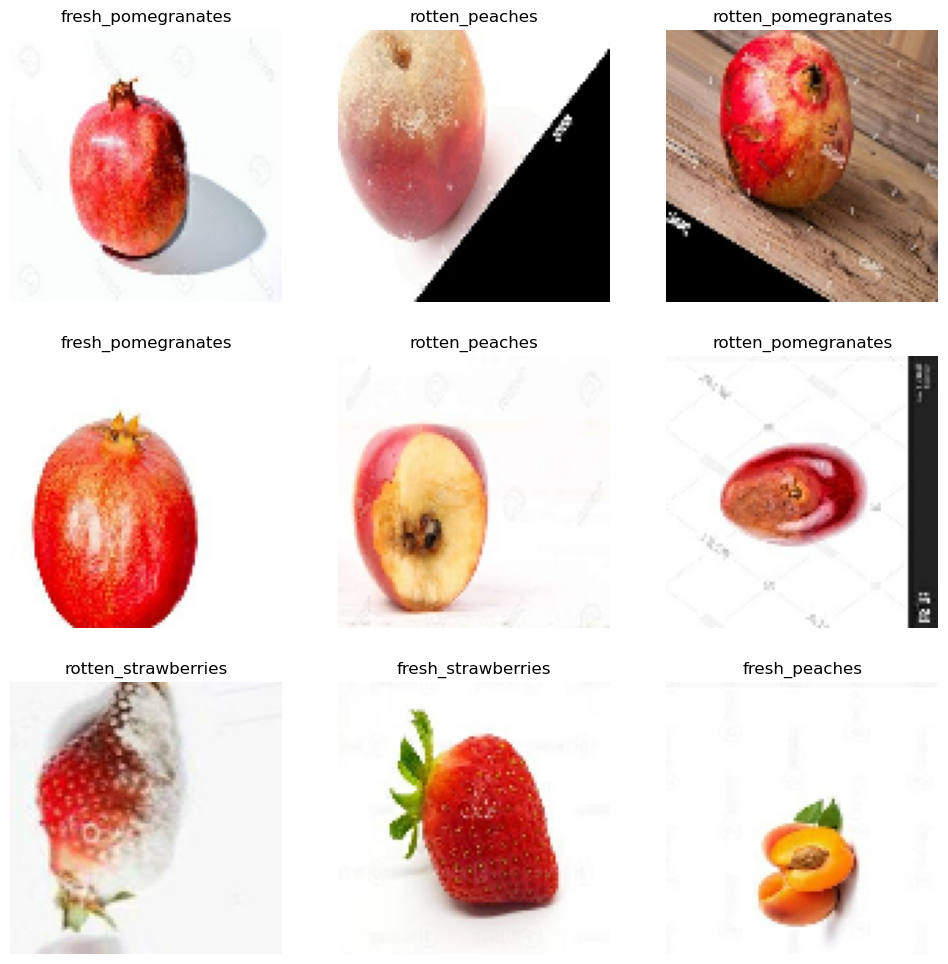

In [6]:
# Samples
class_names = train_ds.class_names
print(class_names)

plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

## Preprocessing

- Autotune: Digunakan untuk menentukan jumlah buffer yang sesuai untuk pipeline data secara otomatis. Menyimpan data pada cache(), shuffle () untuk mengacak urutan untuk mengurangi bias pada gambar, dan prefetching() untuk pemrosesan data secara parallel
- Augmentasi: Augmentasi kembali dilakukan untuk meningkatkan akurasi serta menurunkan persentasi loss pada saat training dan validasi data

In [39]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(buffer_size=batch_size).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().shuffle(buffer_size=batch_size).prefetch(buffer_size=AUTOTUNE)

num_classes = len(class_names)

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.5), #50%
    layers.RandomZoom(0.2), #20%
    layers.RandomContrast(0.2), #20%
])

- Model Arsitektur sekuensial (tumpukan linear dari beberapa lapisan) cnn dengan compiler adam untuk klasifikasi buah
    1. Rescaling: konversi nilai piksel dari bit 0-255 menjadi 0-1
    2. Menambahkan layer konvolusi dengan 16, 32, 64, dam 128 filter, ukuran kernel 3x3, dan fungsi aktivasi ReLU.
    3. Menambahkan layer pooling untuk mengurangi dimensi spasial gambar setelah konvolusi, mengambil nilai maksimum dalam window 2x2 secara default.
    4. Flatten untuk meratakan dimensi dari 2D ke 1D
    5. Dense berfungsi untuk memetakan fitur yang diekstraksi oleh layer sebelumnya

- Mengompilasi model dengan optimizer Adam, menggunakan Sparse Categorical Crossentropy untuk menampilkan diagram akurasi dan loss dari data training dan data validasi
    

In [40]:
from tensorflow.keras import Input

model = Sequential([
    Input(shape=(img_height, img_width, 3)), 
    layers.Rescaling(1./255),
    data_augmentation,
    layers.Conv2D(16, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),  
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),  
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_4 (Rescaling)         │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_5 (Sequential)       │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 98, 98, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 49, 49, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 47, 47, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 21, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 623,526 (2.38 MB)

 Trainable params: 623,526 (2.38 MB)

 Non-trainable params: 0 (0.00 B)

Dilakukan iterasi penuh (epoch) terhadap data training sebanyak 16x iterasi untuk melakukan training model dalam menentukan tingkat akurasi dan loss nya terhadap data validasi. 

In [41]:
## Training Model
epochs = 16
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

# Data train 2740/32 = 86
# Batch Size = 32

Epoch 1/16
86/86 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.2761 - loss: 1.6466 - val_accuracy: 0.4371 - val_loss: 1.3220
Epoch 2/16
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.4721 - loss: 1.2801 - val_accuracy: 0.6082 - val_loss: 1.0582
Epoch 3/16
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.5966 - loss: 1.0696 - val_accuracy: 0.6974 - val_loss: 0.9127
Epoch 4/16
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.6841 - loss: 0.8437 - val_accuracy: 0.6535 - val_loss: 0.9233
Epoch 5/16
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.7301 - loss: 0.6965 - val_accuracy: 0.6798 - val_loss: 0.9297
Epoch 6/16
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.7571 - loss: 0.6256 - val_accuracy: 0.7851 - val_loss: 0.5364
Epoch 7/16
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.7850 - loss: 0.5712 - val_accuracy: 0.8202 - val_loss: 0.4770
Epoch 8/16
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.8008 - loss: 0.5235 - val_accuracy: 0.7749 - v

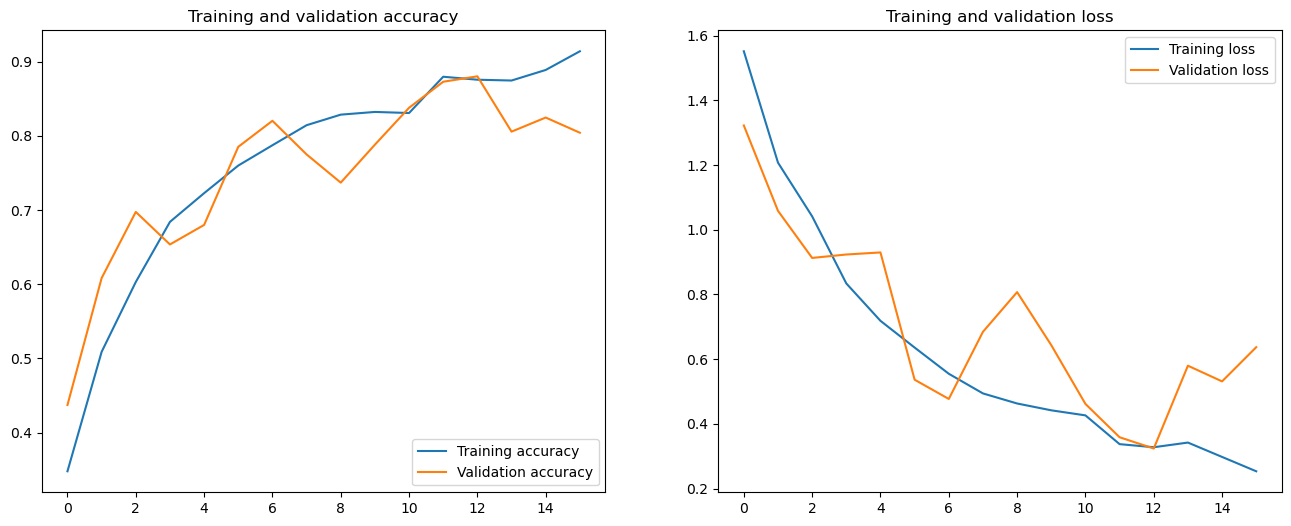

In [42]:
## Model Accuracy Plot
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training accuracy')
plt.plot(epochs_range, val_acc, label='Validation accuracy')
plt.legend(loc='lower right')
plt.title('Training and validation accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training loss')
plt.plot(epochs_range, val_loss, label='Validation loss')
plt.legend(loc='upper right')
plt.title('Training and validation loss')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


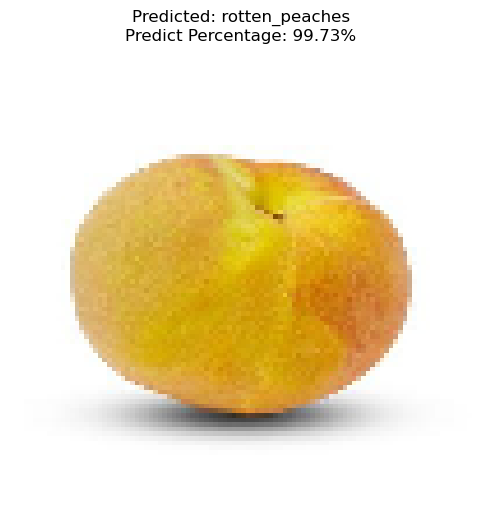

In [45]:
## Testing
tes_fruit = "D:/Mata Kuliah - TI/Semester 4/Pengolahan Citra Digital/Praktikum/Project PCD/Dataset_F_Augmen/fresh_peaches/fresh_peaches_5_original.jpg"
img = tf.keras.utils.load_img(tes_fruit, target_size=(img_height, img_width))
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions_img = model.predict(img_array)
score_img = tf.nn.softmax(predictions_img[0])
predicted_class = class_names[np.argmax(score_img)]
percentage = 100 * np.max(score_img)

plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.title(f"Predicted: {predicted_class}\nPredict Percentage: {percentage:.2f}%")
plt.axis('off')
plt.show()

Preprocessing berupa resize dan flatten untuk modeling CNN

In [54]:
# Preprocess untuk CNN modeling
def preprocess_image(image, label):
    image = tf.image.resize(image, (img_height, img_width))
    image = image / 255.0
    return image.numpy().flatten(), label

train_images, train_labels = zip(*[preprocess_image(image, label) for image, label in train_ds.unbatch()])
val_images, val_labels = zip(*[preprocess_image(image, label) for image, label in val_ds.unbatch()])

In [55]:
train_images = np.array(train_images)
train_labels = np.array(train_labels)
val_images = np.array(val_images)
val_labels = np.array(val_labels)
val_images, test_images, val_labels, test_labels = train_test_split(val_images, val_labels, test_size=0.5, random_state=256)

Preprocessing kembali untuk CNN model dengan menggunakan normalisasi standarisasi dan PCA. PCA (Principal component analysys) digunakan untuk mengurangi dimensi data, sambil mempertahankan 0.95 (95%) varian dari dataset asli.

In [56]:
from sklearn.decomposition import PCA

scaler = StandardScaler()
train_images = scaler.fit_transform(train_images)
test_images = scaler.transform(test_images)

pca = PCA(n_components=0.95)  
train_images = pca.fit_transform(train_images)
test_images = pca.transform(test_images)

In [57]:
# KNN Classifier
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')
knn.fit(train_images, train_labels)
knn_pred = knn.predict(test_images)
knn_acc = accuracy_score(test_labels, knn_pred)
knn_precision = precision_score(test_labels, knn_pred, average='weighted')
knn_recall = recall_score(test_labels, knn_pred, average='weighted')
knn_f1 = f1_score(test_labels, knn_pred, average='weighted')


# SVC Classifier
svc = SVC(C=10, kernel='rbf')
svc.fit(train_images, train_labels)
svc_pred = svc.predict(test_images)
svc_acc = accuracy_score(test_labels, svc_pred)
svc_precision = precision_score(test_labels, svc_pred, average='weighted')
svc_recall = recall_score(test_labels, svc_pred, average='weighted')
svc_f1 = f1_score(test_labels, svc_pred, average='weighted')

# Random Forest Classifier
rf = RandomForestClassifier(n_estimators=200,  random_state=42)
rf.fit(train_images, train_labels)
rf_pred = rf.predict(test_images)
rf_acc = accuracy_score(test_labels, rf_pred)
rf_precision = precision_score(test_labels, rf_pred, average='weighted')
rf_recall = recall_score(test_labels, rf_pred, average='weighted')
rf_f1 = f1_score(test_labels, rf_pred, average='weighted')

header = f"{' |':<10}  │ {'Accuracy':<10} │ {'Precision':<10} │ {'Recall':<10} │ {'F1 Score':<10} |"
separator = "─" * 62

top_border = f" ┌{'─' * 10}┬{'─' * 12}┬{'─' * 12}┬{'─' * 12}┬{'─' * 12}┐"
mid_border = f" ├{'─' * 10}┼{'─' * 12}┼{'─' * 12}┼{'─' * 12}┼{'─' * 12}┤"
bottom_border = f" └{'─' * 10}┴{'─' * 12}┴{'─' * 12}┴{'─' * 12}┴{'─' * 12}┘"

row_knn = f"{' |KNN':<10}  │ {knn_acc:<10.8f} │ {knn_precision:<10.8f} │ {knn_recall:<10.8f} │ {knn_f1:<10.8f} |"
row_svc = f"{' |SVC':<10}  │ {svc_acc:<10.8f} │ {svc_precision:<10.8f} │ {svc_recall:<10.8f} │ {svc_f1:<10.8f} |"
row_rf = f"{' |RF':<10}  │ {rf_acc:<10.8f} │ {rf_precision:<10.8f} │ {rf_recall:<10.8f} │ {rf_f1:<10.8f} |"

print(top_border)
print(header)
print(mid_border)
print(row_knn)
print(mid_border)
print(row_svc)
print(mid_border)
print(row_rf)
print(bottom_border)


 ┌──────────┬────────────┬────────────┬────────────┬────────────┐
 |          │ Accuracy   │ Precision  │ Recall     │ F1 Score   |
 ├──────────┼────────────┼────────────┼────────────┼────────────┤
 |KNN       │ 0.76900585 │ 0.78275803 │ 0.76900585 │ 0.77161353 |
 ├──────────┼────────────┼────────────┼────────────┼────────────┤
 |SVC       │ 0.80116959 │ 0.81482910 │ 0.80116959 │ 0.80159854 |
 ├──────────┼────────────┼────────────┼────────────┼────────────┤
 |RF        │ 0.79239766 │ 0.80590943 │ 0.79239766 │ 0.79520332 |
 └──────────┴────────────┴────────────┴────────────┴────────────┘


Dilakukan proses validasi terhadap direktori data_val dengan modeling CNN, untuk menampilkan skor akurasi, presisi, recall, dan f1 dengan format CNN

In [58]:
# Validasi dengan CNN model
from sklearn.metrics import classification_report

test_url = "data_val"
test_ds = tf.keras.utils.image_dataset_from_directory( 
    test_url, 
    # seed=256, 
    image_size=(img_height, img_width),
    shuffle=False 
)

# Make predictions using the CNN model
predictions = model.predict(test_ds)
score = tf.nn.softmax(predictions)
y_pred = np.argmax(score, axis=1)

# Get true labels
y_test = np.concatenate([y for x, y in test_ds], axis=0)

# Print classification report
print(classification_report(y_test, y_pred, target_names=class_names))

Found 850 files belonging to 6 classes.
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
                     precision    recall  f1-score   support

      fresh_peaches       0.99      0.67      0.80       152
 fresh_pomegranates       0.96      0.74      0.84       149
 fresh_strawberries       0.76      0.96      0.85       139
     rotten_peaches       0.75      0.56      0.64       146
rotten_pomegranates       0.68      0.96      0.80       138
rotten_strawberries       0.74      0.91      0.82       126

           accuracy                           0.79       850
          macro avg       0.81      0.80      0.79       850
       weighted avg       0.82      0.79      0.79       850



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


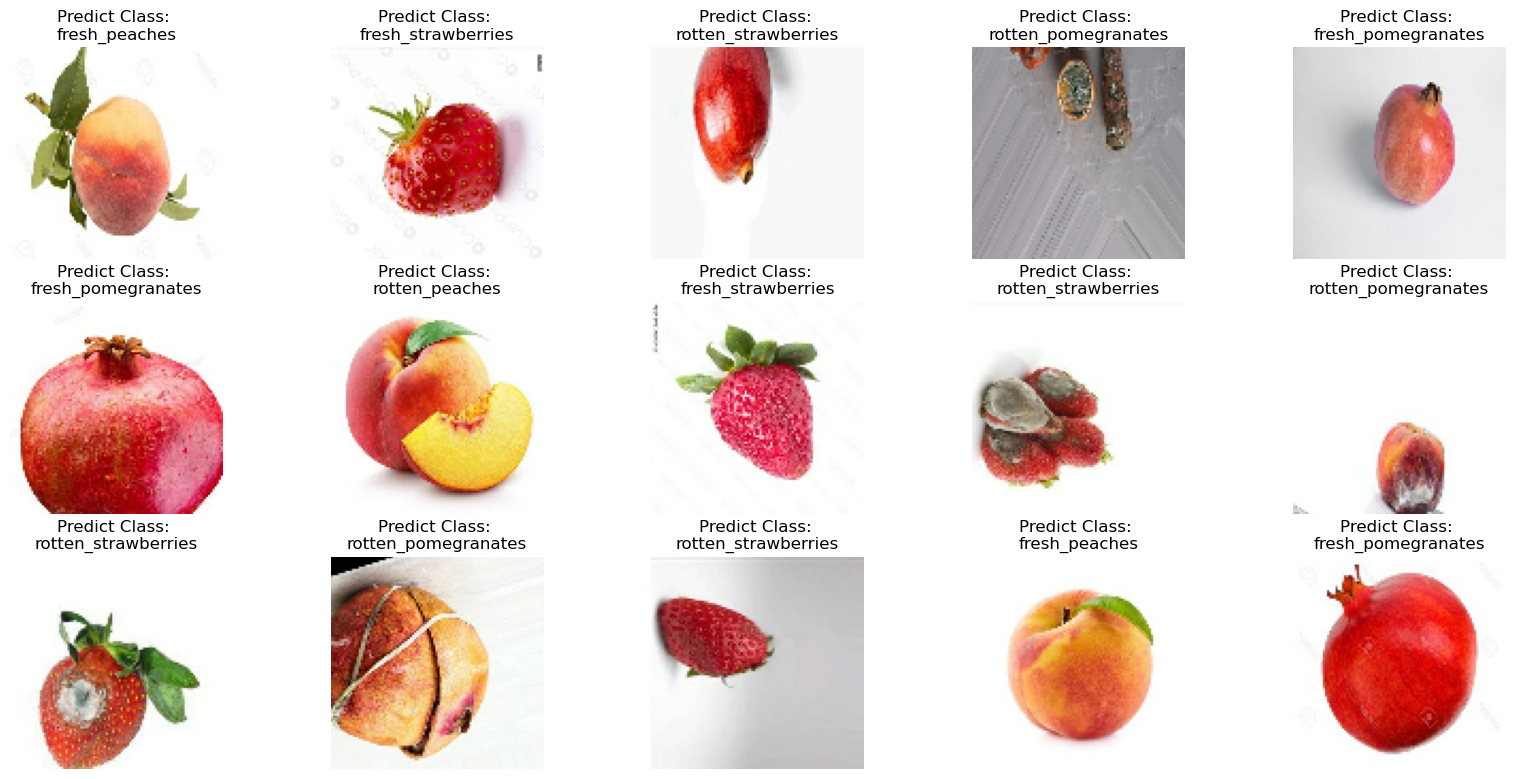

In [60]:
# Display random sampel 
image_batch, label_batch = next(iter(train_ds))
prediction_batch = model.predict(image_batch)
score_batch = tf.nn.softmax(prediction_batch)
plt.figure(figsize=(20, 16))
for i in range(15):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    label = label_batch[i]
    plt.title("Predict Class: \n" + class_names[np.argmax(score_batch[i])])
    plt.axis("off")
